In [1]:
from dataclasses import asdict, dataclass

import torch
import wandb
from contextual_distros import ContextDataset, ContextualLatentSpaceGMM
from dvi_process import DIS
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml

device =  torch.device("cpu") 
# device = torch_directml.device() 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-2
    size = 8192
    batch_size = 8192

config = Config()

In [4]:
dataset = ContextDataset(size=config.size, c_dim=config.c_dim, max_context_size=10, sampling_factor=4, variably_sized_context=True)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
score_function = ScoreFunction(
    c_dim=config.c_dim, 
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    variably_sized_context=True
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    score_function=score_function
).to(device)

In [6]:
target_constructor = ContextualLatentSpaceGMM

In [7]:
wandb_logging = False
if wandb_logging:
    wandb.init(project="dvi", config=asdict(config))

In [8]:
num_epochs = 1000

optimizer = torch.optim.Adam(dvi_process.parameters(), lr=config.learning_rate)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 1 if epoch < 1000 else 0.1)
# scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

In [9]:
losses = train(
    dvi_process, 
    device, 
    num_epochs,
    dataloader, 
    target_constructor,
    optimizer, 
    scheduler,
    wandb_logging=wandb_logging
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'contextual_distros.ContextualLatentSpaceGMM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

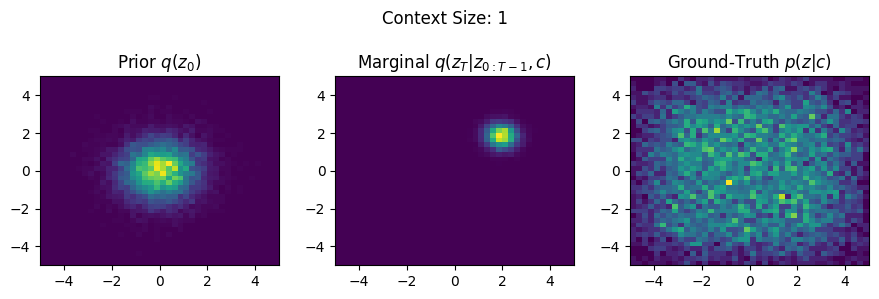

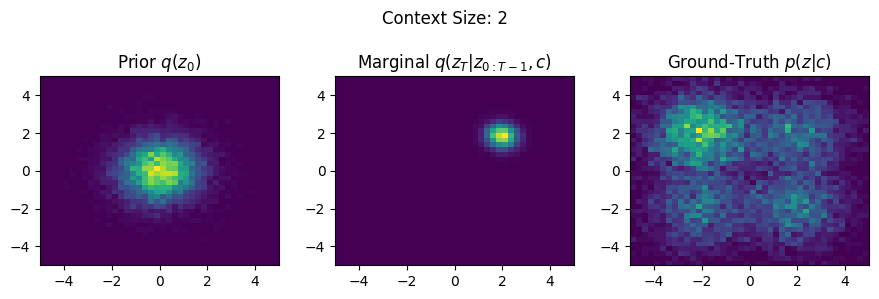

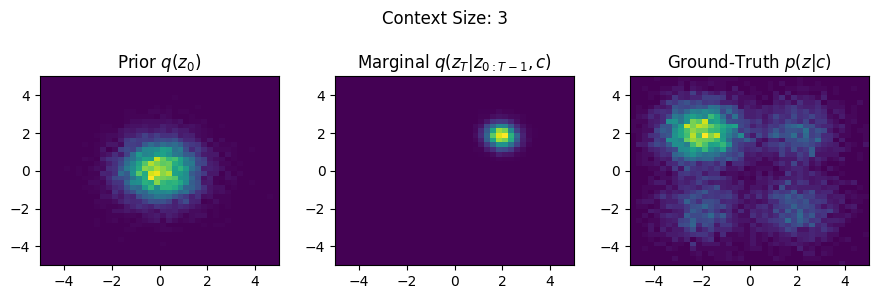

In [10]:
device = torch.device("cpu")

dvi_process = dvi_process.to(device)

num_samples = 10000

for context_size in range(1, 4): # dataset.max_context_size + 1):

    context = 4 * torch.rand((num_samples, context_size, config.c_dim), device=device)
    context[:, :, 0] = context[:, :, 0] * -1
    context[:, :, 1] = context[:, :, 1] * 1

    p_z_T = target_constructor(context)

    z_target_samples = p_z_T.sample()

    dvi_process.eval()
    with torch.no_grad():
        _, z_samples = dvi_process.run_chain(p_z_T, context.to(device))

        z_0_samples = z_samples[0]
        z_T_samples = z_samples[-1]

        z_trajectories = [[z[i, :].cpu().numpy() for z in z_samples] for i in range(num_samples)]

    bins = 40
    plot_range = [(-5, 5), (-5, 5)]

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

    ax[0].hist2d(z_0_samples[:, 0], z_0_samples[:, 1], bins=bins, range=plot_range)
    ax[0].set_title("Prior $q(z_0)$")

    ax[1].hist2d(z_T_samples[:, 0], z_T_samples[:, 1], bins=bins, range=plot_range)
    ax[1].set_title("Marginal $q(z_T|z_{0:T-1},c)$")

    ax[2].hist2d(z_target_samples[:, 0], z_target_samples[:, 1], bins=bins, range=plot_range)
    ax[2].set_title("Ground-Truth $p(z|c)$")

    plt.suptitle("Context Size: {}".format(context_size))
    plt.tight_layout()
    plt.show()

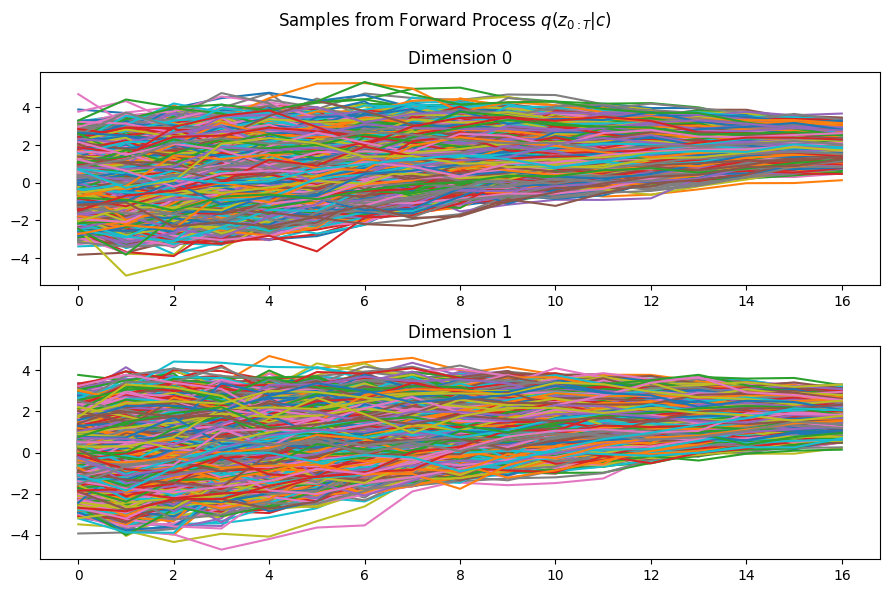

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

for i in range(num_samples):
    ax[0].plot([z[0] for z in z_trajectories[i]])
    ax[0].set_title("Dimension 0")

    ax[1].plot([z[1] for z in z_trajectories[i]])
    ax[1].set_title("Dimension 1")
    
plt.suptitle("Samples from Forward Process $q(z_{0:T}|c)$")

plt.tight_layout()
plt.show()